In [8]:
from tqdm import tqdm
import pickle
import pandas as pd
from pathlib import Path
import numpy as np
import scipy
import copy
import sys
import os
from typing import Optional, Union, Sequence, Mapping, List, Set
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib import rc
from matplotlib import cm
from matplotlib.lines import Line2D
import warnings
from mpl_toolkits.axes_grid1 import make_axes_locatable
from sklearn.metrics.pairwise import cosine_similarity,cosine_distances
from scipy.stats import sem
from matplotlib.ticker import FormatStrFormatter

sys.path.append('/mnt/c/Users/lslat/Code/')
sys.path.append('/mnt/c/Users/lslat/QiskitProjects/VariationalWavefunction/')

from quantum_kernel.code.utils import get_dataset
from quantum_kernel.code.visualization_utils import aggregate_shapes,filter_df
from quantum_kernel.code.kernel_measures.kernel_geometry import purity_average, purity_of_average,geometric_difference,geometric_distance
from quantum_kernel.code.kernel_measures.eigenvalue_scaling import get_eigenvalue_scaling,compute_dataframe_kernel_eigenvalues

font = {'family': 'DejaVu Sans',
        'weight': 'bold',
        'size': 30}

rc('font', **font)

tqdm.pandas()
warnings.filterwarnings("ignore")


In [3]:
# Get kernel results for the different ml models and dataset.d
dfs = {}

folders = [
    ("/mnt/c/Users/lslat/Data/QK_project/results/HZZ_multi/final_gennorm/non_data_layer_test/beta1.0/",'HZZ_Multi'),
    ("/mnt/c/Users/lslat/Data/QK_project/results/HZZ_multi/final_gennorm/non_data_layer_test/beta1.0/gamma0.3/",'HZZ_Multi'),

]

cols_to_drop=['args', 'K_train_time', 'rdms', 
'samples', 'mu','sigma', 'outpath', 'projected']

def get_dfs_from_folder(folder,prefix,cols_to_drop):
    dfs={}
    dfs[prefix] = aggregate_shapes(folder,prefix,cols_to_drop=cols_to_drop)
    return dfs

dfs_list=[get_dfs_from_folder(folder[0],folder[1],cols_to_drop) for folder in folders]

In [4]:
save_folder='/mnt/c/Users/lslat/Data/QK_project/results/figs/'

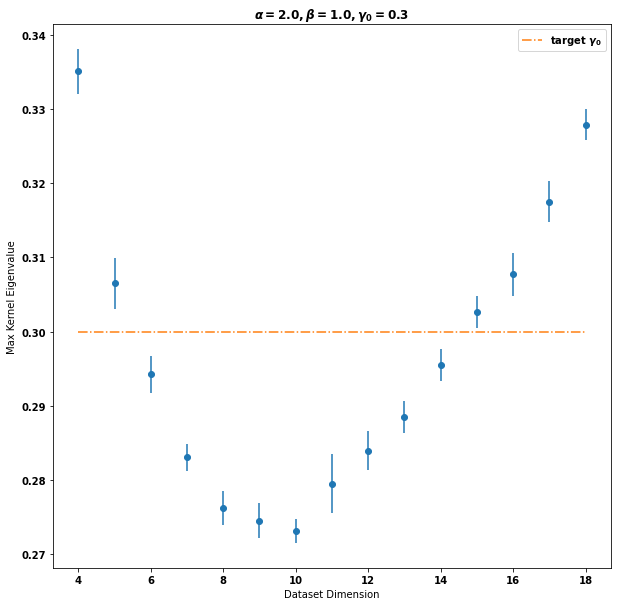

In [5]:
fig, axs = plt.subplots(1,figsize=(10,10))
ax=axs
ax.set_ylabel('Max Kernel Eigenvalue')
beta=1.0
alpha=2.0
gamma=0.3
ndisf=1.0
iqp_df=dfs_list[1]['HZZ_Multi']
filter={'beta': beta,'alpha':alpha,'h_layer':0,'non_data_int_scaling_factor':ndisf}
target_iqp_df=filter_df(iqp_df,filter)
xp=list(set(target_iqp_df.dataset_dim.values))
yp=[np.mean(target_iqp_df[target_iqp_df.dataset_dim==x].apply(lambda x: max(x.kernel_eigenvalues),axis=1).values) for x in xp]
yerr=[sem(target_iqp_df[target_iqp_df.dataset_dim==x].apply(lambda x: max(x.kernel_eigenvalues),axis=1).values) for x in xp]

ax.errorbar(xp,yp,yerr=yerr,fmt='o',ls='')
ax.set_xlabel('Dataset Dimension')
ax.set_title(rf'$\alpha={alpha}, \beta={beta}, \gamma_{0}={gamma}$',color='black')

ax.plot(xp,len(xp)*[gamma],ls='-.',label=r'target $\gamma_{0}$')
ax.legend()
#fig.savefig(f'{save_folder}IQP_max_eigval_v_dim_fixed_beta{beta}.png')

In [6]:

dataset_dims=[4,5,6,7,8,9,10,11,12,13,14,15,16,17,18]
seeds = set(target_iqp_df.seed.values)

beta=1.0
alpha=2.0
gamma=0.3
ndisf=1.0
folder="/mnt/c/Users/lslat/Data/QK_project/results/HZZ_multi/final_gennorm/non_data_layer_test/beta1.0/"

filepath=save_folder+f'geometric_difference_dict_non_data_layer_{ndisf}_beta{beta}_alpha{alpha}_gamma_{gamma}.p'
if os.path.exists(filepath):
    with open(filepath, 'rb') as pickle_file:
        geo_diffs=pickle.load(pickle_file)
else:
    geo_diffs={}

    iqp_df=dfs_list[1]['HZZ_Multi']
    filter={'beta': beta,'alpha':alpha,'h_layer':0,'non_data_int_scaling_factor':1.0}
    target_iqp_df=filter_df(iqp_df,filter)

    for dim in dataset_dims:
        print(f'on dimension: {dim}')
        prefix=f"HZZ_Multi_dim_{dim}*hlayer_0"

        dfs=get_dfs_from_folder(folder,prefix,cols_to_drop)
        generic_ciqp_df=dfs[prefix]

        geo_diffs[str(dim)]=[]
        for seed in seeds:
            c_df=generic_ciqp_df[(generic_ciqp_df['seed']==seed) & (generic_ciqp_df['alpha']==alpha) & (generic_ciqp_df['dataset_dim']==dim) & (generic_ciqp_df['non_data_int_scaling_factor']==0)]
            q_df=target_iqp_df[(target_iqp_df['dataset_dim']==dim) & (target_iqp_df['seed']==seed) & (target_iqp_df['alpha']==alpha)]
            Kq=q_df.qkern_matrix_train.values[0]
            Kcs=c_df.qkern_matrix_train.values
            sfs=c_df.scaling_factor.values
            geo_diffs[str(dim)]=geo_diffs[str(dim)]+[(sf,geometric_difference(Kq,Kc)) for sf,Kc in zip(sfs,Kcs)]
        geo_diffs[str(dim)]=np.array(geo_diffs[str(dim)])

    with open(filepath, 'wb') as f:
        try:
            pickle.dump(geo_diffs,f)
        except:
            print('Could not save geo_diffs dictionary')

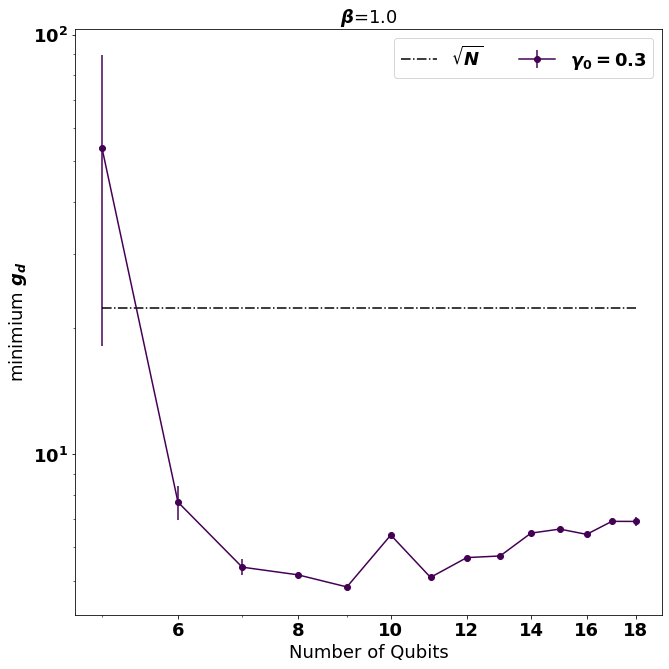

In [15]:
colormap=cm.viridis
dataset_dims=[5,6,7,8,9,10,11,12,13,14,15,16,17,18]
fig, axs = plt.subplots(1,figsize=(10,10),sharey=True)

beta=1.0
alpha=2.0
gamma=0.3

filepath=save_folder+f'geometric_difference_dict_non_data_layer_{ndisf}_beta{beta}_alpha{alpha}_gamma_{gamma}.p'
if os.path.exists(filepath):
    with open(filepath, 'rb') as pickle_file:
        geo_diffs=pickle.load(pickle_file)
else:
    pass
ax=axs

color_index=0
color=colormap.colors[color_index]

ys=[]
yerrs=[]
for dim in dataset_dims:
    x=list(set(geo_diffs[str(dim)][:,0]))
    y=min([np.mean(geo_diffs[str(dim)][geo_diffs[str(dim)][:,0]==a][:,1]) for a in x])
    index = [np.mean(geo_diffs[str(dim)][geo_diffs[str(dim)][:,0]==a][:,1]) for a in x].index(y)
    yerr=[sem(geo_diffs[str(dim)][geo_diffs[str(dim)][:,0]==a][:,1]) for a in x][index]

    ys.append(y)
    yerrs.append(yerr)
ax.errorbar(dataset_dims,ys,yerr=yerrs,color=color,fmt='-o',label=rf'$\gamma_0={gamma}$')

ax.set_yscale('log')
ax.set_xscale('log')
ax.set_ylabel('minimium $g_d$',fontsize=18)
ax.set_xlabel('Number of Qubits',fontsize=18)
ax.set_xticks(np.arange(4, 20, step=2))  # Set label locations.
ax.xaxis.set_major_formatter(FormatStrFormatter('%.f'))
ax.tick_params(axis='both',labelsize=18)

ax.plot(dataset_dims,len(dataset_dims)*[np.sqrt(500)],ls='-.',color='black',label=r'$\sqrt{N}$')

legend=plt.legend(ncol=2,bbox_to_anchor=(1,1),fontsize=18,title_fontsize=18)
#legend.set_title('Dataset Dimension')

ax.set_title(rf'$\beta$={beta}',fontsize=18)

fig.tight_layout()
fig.savefig(f'{save_folder}heisenberg_gd_decay_fixed_beta{beta}.pdf')